# Hands-on Machine Learning (ML) and Sequential Learning (SL)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/AEM/blob/main/2-Hands-on_ML_SL.ipynb)

In [ ]:
%pip install pymatgen==2020.1.28
%pip install matminer==0.6.2
%pip install scikit_learn==0.22.2
%pip install shap==0.38.1

In [ ]:
import numpy as np
import pandas as pd
import shap
import sklearn
from matminer.featurizers import composition as cf
from matminer.featurizers.base import MultipleFeaturizer
from pymatgen import Composition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
class MyDecorrelator(BaseEstimator, TransformerMixin):
    """Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage."""

    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if (
                    abs(corr_matrix.iloc[i, j]) > self.threshold
                ):  # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        # print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [ ]:
def get_compostion(
    c,
):  # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:  # noqa: E722
        return None


def featurizing(data, property_interest=None):

    # Featurizer
    f = MultipleFeaturizer(
        [
            cf.Stoichiometry(),
            cf.ElementProperty.from_preset("magpie"),
            cf.ValenceOrbital(props=["avg"]),
            cf.IonProperty(fast=True),
        ]
    )

    # Inputs
    data["composition"] = [get_compostion(mat) for mat in data.Components]

    featurized_data = pd.DataFrame(
        f.featurize_many(data["composition"], ignore_errors=True),
        columns=f.feature_labels(),
        index=data["Components"],
    )
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

## Handle data


1.   Import data (composition and target property for each material)
2.   Extract 145 composition based features for each material
3.   Drop rows with NaN
4.   Split data in a training set (80% of the database) and in a testing set (20% of the database)





In [ ]:
data = pd.read_excel(r"Supercon_data_clean.xlsx")  # Import data

In [ ]:
Featurized_data = featurizing(data, "Tc")  # Extract composition based features

MultipleFeaturizer: 100%|██████████| 12919/12919 [00:42<00:00, 302.73it/s]


In [ ]:
Featurized_data

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
H3S,2.0,0.790569,0.759147,0.750616,0.750049,0.750001,1.0,16.0,15.0,4.750000,...,46.500000,194.0,1.250000,1.000000,0.000000,0.000000,False,0.035456,0.006648,147.0
Ba100Ca99Cu145Hg33O420Pb17,6.0,0.574387,0.527459,0.516629,0.516020,0.515972,8.0,82.0,74.0,23.561425,...,104.430150,12.0,1.821867,2.105651,2.395577,0.859951,False,0.803211,0.165437,143.0
Ba1035Ca1035Cu1555Hg375O4104,5.0,0.572747,0.520734,0.507411,0.506507,0.506420,8.0,80.0,72.0,23.024062,...,104.234706,12.0,1.808119,2.025666,2.381540,0.647828,False,0.803211,0.167923,135.8
Ba2070Ca2070Cu3110Hg750O8187,5.0,0.572343,0.520183,0.506782,0.505868,0.505780,8.0,80.0,72.0,23.043553,...,104.237962,12.0,1.807871,2.023105,2.384630,0.648669,False,0.803211,0.167961,135.4
Ba200Ca200Cu300Hg100O829,5.0,0.571674,0.521679,0.509699,0.508967,0.508903,8.0,80.0,72.0,23.653775,...,103.279758,12.0,1.815838,2.035605,2.455494,0.859423,False,0.803211,0.166091,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As9Fe10La10O10P,5.0,0.488621,0.387712,0.322828,0.298729,0.282116,8.0,57.0,49.0,30.550000,...,74.282500,12.0,2.000000,1.750000,4.000000,0.000000,True,0.745613,0.122382,0.0
As200Ca81Ce19Fe100,4.0,0.596458,0.530189,0.504146,0.500683,0.500055,20.0,58.0,38.0,29.805000,...,29.125113,166.0,2.000000,1.500000,6.547500,0.047500,False,0.293972,0.048801,0.0
As18Fe20O20P2Pr13Sr7,6.0,0.458598,0.362455,0.305205,0.285416,0.272440,8.0,59.0,51.0,29.212500,...,75.774375,12.0,2.000000,1.750000,3.750000,0.487500,False,0.787757,0.124658,0.0


In [ ]:
Featurized_data = Featurized_data.dropna()

In [ ]:
Featurized_data

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
H3S,2.0,0.790569,0.759147,0.750616,0.750049,0.750001,1.0,16.0,15.0,4.750000,...,46.500000,194.0,1.250000,1.000000,0.000000,0.000000,False,0.035456,0.006648,147.0
Ba100Ca99Cu145Hg33O420Pb17,6.0,0.574387,0.527459,0.516629,0.516020,0.515972,8.0,82.0,74.0,23.561425,...,104.430150,12.0,1.821867,2.105651,2.395577,0.859951,False,0.803211,0.165437,143.0
Ba1035Ca1035Cu1555Hg375O4104,5.0,0.572747,0.520734,0.507411,0.506507,0.506420,8.0,80.0,72.0,23.024062,...,104.234706,12.0,1.808119,2.025666,2.381540,0.647828,False,0.803211,0.167923,135.8
Ba2070Ca2070Cu3110Hg750O8187,5.0,0.572343,0.520183,0.506782,0.505868,0.505780,8.0,80.0,72.0,23.043553,...,104.237962,12.0,1.807871,2.023105,2.384630,0.648669,False,0.803211,0.167961,135.4
Ba200Ca200Cu300Hg100O829,5.0,0.571674,0.521679,0.509699,0.508967,0.508903,8.0,80.0,72.0,23.653775,...,103.279758,12.0,1.815838,2.035605,2.455494,0.859423,False,0.803211,0.166091,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As9Fe10La10O10P,5.0,0.488621,0.387712,0.322828,0.298729,0.282116,8.0,57.0,49.0,30.550000,...,74.282500,12.0,2.000000,1.750000,4.000000,0.000000,True,0.745613,0.122382,0.0
As200Ca81Ce19Fe100,4.0,0.596458,0.530189,0.504146,0.500683,0.500055,20.0,58.0,38.0,29.805000,...,29.125113,166.0,2.000000,1.500000,6.547500,0.047500,False,0.293972,0.048801,0.0
As18Fe20O20P2Pr13Sr7,6.0,0.458598,0.362455,0.305205,0.285416,0.272440,8.0,59.0,51.0,29.212500,...,75.774375,12.0,2.000000,1.750000,3.750000,0.487500,False,0.787757,0.124658,0.0


In [ ]:
train_df, test_df = train_test_split(
    Featurized_data, test_size=0.2, random_state=0
)  # split data in training set (80% of the database) and testing set (20% of the database)

In [ ]:
train_df

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
BCa2Cu3O9Sr2,5.0,0.585287,0.539856,0.529963,0.529450,0.529413,5.0,38.0,33.0,16.470588,...,102.456747,12.0,1.823529,2.176471,1.764706,0.000000,False,0.787757,0.162616,75.000
B47C3Mg25,3.0,0.710931,0.656696,0.631915,0.627740,0.626780,5.0,12.0,7.0,7.373333,...,13.101511,166.0,2.000000,0.706667,0.000000,0.000000,False,0.319141,0.031888,32.900
As50Ba25Co4Fe46,4.0,0.580041,0.495790,0.444278,0.426456,0.414721,26.0,56.0,30.0,34.832000,...,29.899520,166.0,2.000000,1.200000,6.432000,0.000000,True,0.340336,0.047937,22.720
CsO6Os,3.0,0.770552,0.752308,0.750039,0.750001,0.750000,8.0,76.0,68.0,22.375000,...,74.812500,12.0,1.875000,3.000000,0.750000,1.750000,False,0.827201,0.113589,3.300
IrSiTa,3.0,0.577350,0.480750,0.415244,0.389977,0.372041,14.0,77.0,63.0,54.666667,...,1.333333,225.0,2.000000,0.666667,3.333333,9.333333,False,0.115294,0.019639,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GeNb30Sn9,3.0,0.783422,0.756699,0.750364,0.750023,0.750000,32.0,50.0,18.0,42.800000,...,30.645000,229.0,1.250000,0.500000,5.500000,0.000000,False,0.041154,0.006155,17.985
Ba40Cu57O138Y20Zn3,5.0,0.604229,0.551794,0.536387,0.535054,0.534892,8.0,56.0,48.0,22.740310,...,103.688661,12.0,1.779070,2.139535,2.403101,0.000000,False,0.803211,0.162487,32.500
AsHfOs,3.0,0.577350,0.480750,0.415244,0.389977,0.372041,33.0,76.0,43.0,60.333333,...,12.444444,166.0,2.000000,1.000000,6.000000,9.333333,False,0.183314,0.039936,3.200


# Train and validate the predictive model



1.   Define a pipeline of actions to be performed over data
2.   Define a grid of hyperparameters to be tuned
3.   Perform a grid search (i.e., try all the possible combinations of hyperparameters) in 5 fold cross validation
4.   Show the performances of the best pipeline by doing predictions over the testing set



In [ ]:
rf = RandomForestRegressor(random_state=0)

pipe = Pipeline(
    [
        (
            "decorrelation",
            MyDecorrelator(0.9),
        ),  # Drop features with correlation above 0.9
        ("threshold", VarianceThreshold(threshold=0)),  # Drop features with no variance
        (
            "feature_selector",
            SelectPercentile(f_regression),
        ),  # Select features in terms of the most relevant for f_regression
        ("rf", rf),  # Train Random Forest
    ],
    verbose=1,
)

In [ ]:
param_grid = {
    "rf__n_estimators": [100, 200],  # Tune the number of estimators
    "rf__max_features": [
        "auto",
        "sqrt",
    ],  # Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [
        50,
        100,
    ],  # Tune the percentage of features to retain in terms of f_regression score
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1, cv=5)

In [ ]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.3s finished


(10331, 93)
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.9s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ................ (step 4 of 4) Processing rf, total=  37.8s


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_selector',
                                        SelectPercentile(percentile=10,
                                                         score_func=<function f_regression at 0x7faeb1618680>)),
                                       ('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth...
                                                              mi

In [ ]:
search.best_params_

{'feature_selector__percentile': 100,
 'rf__max_features': 'auto',
 'rf__n_estimators': 100}

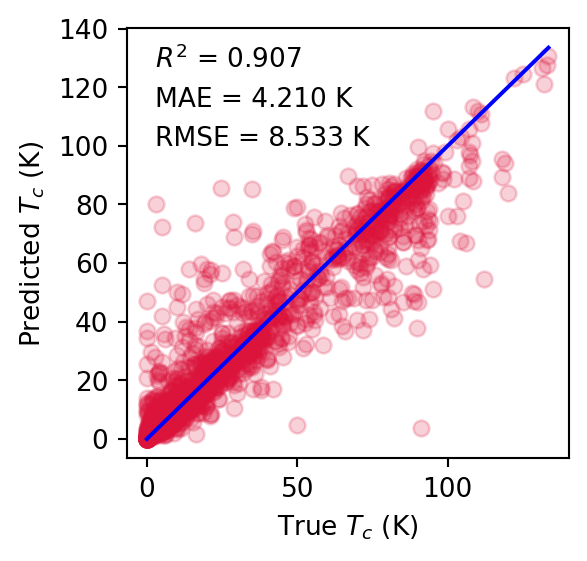

In [ ]:
test_predictions = search.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error
delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.3f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.3f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_c$ (K)")
plt.ylabel("Predicted $T_c$ (K)")
plt.show()

# Manual refit
We manually refit the best pipeline over the all training set, in order to isolate the Random Forest model and to compute the SHAP values with the TreeExplainer over the entire testing set. Otherwise, the pipeline would be seen as a black box by SHAP, and we would be compelled to use the agnostic KernelSHAP interpretation algorithm (which is more inefficient).

In [ ]:
X_train = train_df.iloc[:, :-1].loc[
    :, VarianceThreshold(threshold=0).fit(train_df.iloc[:, :-1]).get_support()
]  # Drop features with 0 variance
X_test = test_df[X_train.columns]

In [ ]:
correlated_features = set()
corr_matrix = X_train.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (
            abs(corr_matrix.iloc[i, j]) > 0.9
        ):  # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)

X_train = X_train.drop(labels=correlated_features, axis=1)  # drop correlated features
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

In [ ]:
X_train = X_train.loc[
    :,
    SelectPercentile(f_regression, percentile=100).fit(X_train, y_train).get_support(),
]  # Select the percentile of best features from the best pipeline
X_test = X_test[X_train.columns]

In [ ]:
X_train

,0-norm,2-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData mean GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData mean SpaceGroupNumber,compound possible
Components,,,,,,,,,,,,,,,,,,,,,
BCa2Cu3O9Sr2,5.0,0.585287,5.0,38.0,33.0,16.470588,10.318339,8.0,7.0,87.0,...,0.168747,0.000,0.0,0.000000,0.000000,0.0,12.0,225.0,108.764706,False
B47C3Mg25,3.0,0.710931,5.0,12.0,7.0,7.373333,3.084444,5.0,68.0,77.0,...,0.756587,1.524,0.0,0.000000,0.000000,0.0,166.0,194.0,176.453333,False
As50Ba25Co4Fe46,4.0,0.580041,26.0,56.0,30.0,34.832000,8.467200,33.0,9.0,84.0,...,0.000000,0.000,0.0,2.110663,0.826275,0.0,166.0,229.0,202.680000,True
CsO6Os,3.0,0.770552,8.0,76.0,68.0,22.375000,21.562500,8.0,5.0,87.0,...,0.000000,0.000,0.0,0.000000,0.000000,0.0,12.0,229.0,61.875000,False
IrSiTa,3.0,0.577350,14.0,77.0,63.0,54.666667,27.111111,14.0,48.0,78.0,...,0.343556,0.000,0.0,0.000000,0.000000,0.0,225.0,229.0,227.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GeNb30Sn9,3.0,0.783422,32.0,50.0,18.0,42.800000,3.240000,41.0,47.0,80.0,...,0.018671,0.000,0.0,0.000000,0.000000,0.0,141.0,229.0,209.100000,False
Ba40Cu57O138Y20Zn3,5.0,0.604229,8.0,56.0,48.0,22.740310,15.768704,8.0,9.0,87.0,...,0.000000,0.000,0.0,0.000000,0.000000,0.0,12.0,229.0,108.926357,False
AsHfOs,3.0,0.577350,33.0,76.0,43.0,60.333333,18.222222,33.0,45.0,84.0,...,0.000000,0.000,0.0,0.000000,0.000000,0.0,166.0,194.0,184.666667,False


In [ ]:
rf = RandomForestRegressor(random_state=0, n_estimators=100, max_features="auto")
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

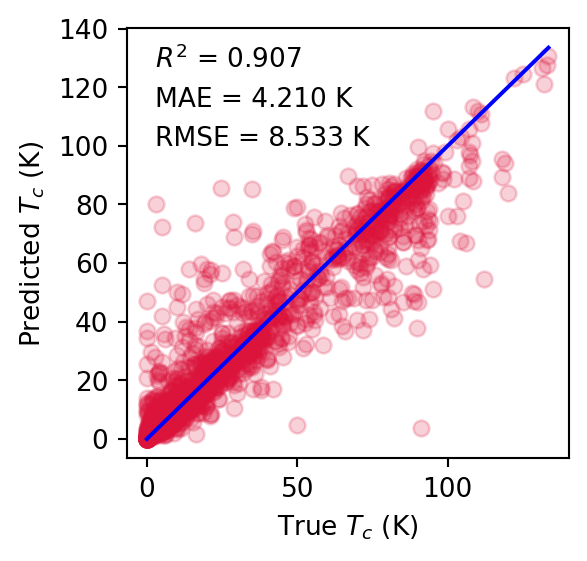

In [ ]:
y_predictions = rf.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_predictions)
mae = mean_absolute_error(y_test, y_predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions))

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, y_predictions, c="crimson", alpha=0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], "b-")

plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.3f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.3f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_c$ (K)")
plt.ylabel("Predicted $T_c$ (K)")
plt.show()

# Interpretability
Thanks to the TreeSHAP algorithm, we can find the most relevant features, ranking them in terms of importance with respect to the output.

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

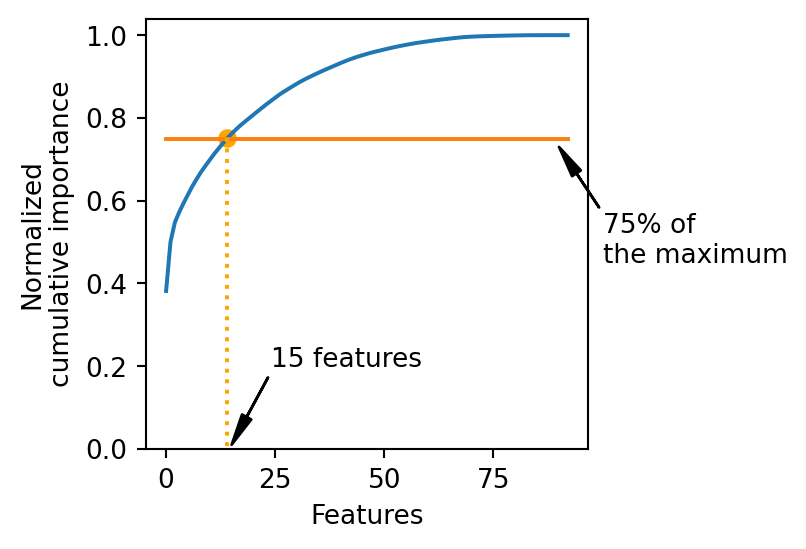

In [ ]:
N = np.shape(X_test)[1]
k = 0.75
import matplotlib.pyplot as plt

cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1])
normalized_cumulative = np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1]) / (
    np.max(np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1]))
)


fig, ax = plt.subplots(figsize=(3, 3), dpi=190)
ax.plot(np.arange(N), normalized_cumulative)
ax.plot(np.arange(N), k * np.ones(N))
ind_cross1 = np.argmin(
    np.fabs(normalized_cumulative - k * max(normalized_cumulative) * np.ones(N))
)
# plt.yticks(np.array([0, 0.5, 1]))

ax.annotate(
    "%i features" % (ind_cross1 + 1),
    xy=(ind_cross1 + 1, 0.01),
    xytext=(ind_cross1 + 10, 0.2),
    arrowprops=dict(facecolor="black", shrink=0.000005, width=0.1, headwidth=4),
)
ax.annotate(
    "75% of\nthe maximum",
    xy=(90, 0.73),
    xytext=(100, 0.45),
    arrowprops=dict(facecolor="black", shrink=0.0005, width=0.1, headwidth=4),
)
plt.scatter(ind_cross1, normalized_cumulative[ind_cross1], color="orange")
plt.plot(
    (ind_cross1, ind_cross1),
    (normalized_cumulative[ind_cross1], 0),
    color="orange",
    ls=":",
)
plt.ylim(0, 1.04)
plt.xlabel("Features")
plt.ylabel("Normalized\ncumulative importance")
plt.show()

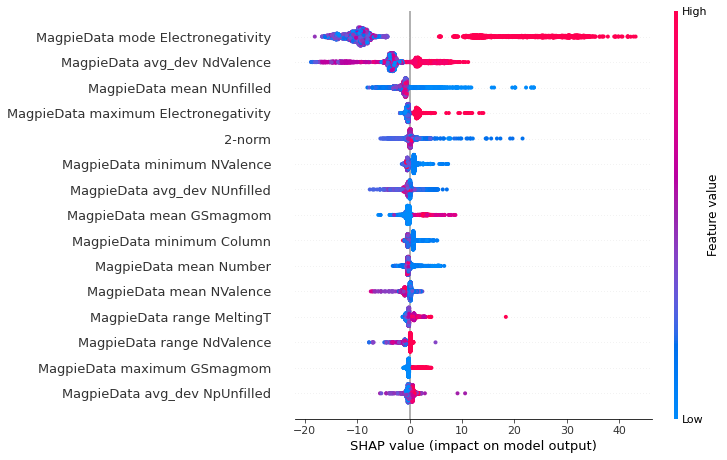

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=15)

In [ ]:
Output_shap = pd.DataFrame(shap_values, index=X_test.index, columns=X_test.columns)
Output_mean_shap = pd.DataFrame(
    abs(Output_shap).describe().loc["mean"]
    / sum(abs(Output_shap).describe().loc["mean"])
).sort_values("mean", ascending=False)

In [ ]:
Output_mean_shap.to_excel(
    "Output_mean_shap.xlsx"
)  # list of the features ranked in terms of importance (importances sum up to 1)

# Sequential Learning
We consider a random subset of 100 rows of the original database; we perform SL starting with the worst 50 materials in this set, in terms of the target property.

With these very same initial conditions, we perform three parallel SL procedures, choosing the next interesting material to be tested with three different acquisition functions: Maximum Expected Improvement (MEI), Maximum Likelihood Improvement (MLI), Maximum Uncertainty (MU).

Since the random forest regressor by lolopy (used to compute $\mu$ and $\sigma$ for each of the materials of the testing set) is not deterministic, at each iteration of SL, given an acquisition function, we repeat the regression, and the consequent choice of the next material, 10 times; we effectively pick the most preferred material. We repeat the procedure for the three acquisition functions in parallel.

We repeat the procedure both with only the relevant features, and with an extended set of features including also non relevant ones.

In [ ]:
%pip install lolopy

In [ ]:
from lolopy.learners import RandomForestRegressor

In [ ]:
def MEI(X: np.ndarray, y: np.ndarray, n_steps: int, T: int) -> int:
    """Acquisition functions MEI.

    Args:
        X (numpy.ndarray): matrix with n rows (number of total materials for
            which doing the SL, in our case 100) and d columns (number of features
            taken into account for the optimization)
        y (

            .ndarray): vector with n rows (target property)
        n_steps (int): number of steps allowed for doing SL (in our case,
            100 total materials - 50 materials in the initial training set
            = maximum 50 steps to find the optimum)
        T (int): number of times the (non-deterministic) regression and
            the consequent choice of the next material is performed

    Returns:
        int: the index of the chosen material
    """

    arr = y
    minima = arr.argsort()[0:50]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    F = np.zeros(n_steps)
    G = np.zeros(n_steps)
    mei_train = [list(set(np.where(in_train)[0].tolist()))]
    mei_train_inds = []

    for i in tqdm.tqdm(range(n_steps)):
        mei_train_inds = mei_train[-1].copy()
        mei_search_inds = list(all_inds.difference(mei_train_inds))

        mei_selection_index = []
        for j in range(T):
            model.fit(X[mei_train_inds], y[mei_train_inds])
            mei_y_pred_prov = model.predict(X[mei_search_inds])
            mei_selection_index.append(np.argmax(mei_y_pred_prov))

        mei_index_G = max(set(mei_selection_index), key=mei_selection_index.count)
        mei_index = mei_search_inds[mei_index_G]  # Pick the most preferred entry
        mei_train_inds.append(mei_search_inds[mei_index_G])
        mei_train.append(mei_train_inds)
        G[i] = mei_index
        F[i] = mei_train_inds[-1]
        if mei_train_inds[-1] == np.argmax(y):
            break

    return F


def MLI(X: np.ndarray, y: np.ndarray, n_steps: int, T: int) -> int:
    """Acquisition functions MLI.

    Args:
        X (numpy.ndarray): matrix with n rows (number of total materials for
            which doing the SL, in our case 100) and d columns (number of features
            taken into account for the optimization)
        y (numpy.ndarray): vector with n rows (target property)
        n_steps (int): number of steps allowed for doing SL (in our case,
            100 total materials - 50 materials in the initial training set
            = maximum 50 steps to find the optimum)
        T (int): number of times the (non-deterministic) regression and
            the consequent choice of the next material is performed

    Returns:
        int: the index of the chosen material
    """
    arr = y
    minima = arr.argsort()[0:50]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    K = np.zeros(n_steps)
    L = np.zeros(n_steps)
    mli_train = [list(set(np.where(in_train)[0].tolist()))]
    mli_train_inds = []

    for i in tqdm.tqdm(range(n_steps)):
        mli_train_inds = mli_train[-1].copy()
        mli_search_inds = list(all_inds.difference(mli_train_inds))

        mli_selection_index = []
        for j in range(T):
            model.fit(X[mli_train_inds], y[mli_train_inds])
            mli_y_pred_prov, mli_y_std_prov = model.predict(
                X[mli_search_inds], return_std=True
            )
            mli_selection_index.append(
                np.argmax(
                    np.divide(
                        mli_y_pred_prov - np.max(y[mli_train_inds]), mli_y_std_prov
                    )
                )
            )

        mli_index_L = max(set(mli_selection_index), key=mli_selection_index.count)
        mli_index = mli_search_inds[mli_index_L]  # Pick the most preferred entry

        mli_train_inds.append(mli_search_inds[mli_index_L])
        mli_train.append(mli_train_inds)
        L[i] = mli_index
        K[i] = mli_train_inds[-1]
        if mli_train_inds[-1] == np.argmax(y):
            break

    return K


def MU(X: np.ndarray, y: np.ndarray, n_steps: int, T: int) -> int:
    """Acquisition functions MU.

    Args:
        X (numpy.ndarray): matrix with n rows (number of total materials for
            which doing the SL, in our case 100) and d columns (number of features
            taken into account for the optimization)
        y (numpy.ndarray): vector with n rows (target property)
        n_steps (int): number of steps allowed for doing SL (in our case,
            100 total materials - 50 materials in the initial training set
            = maximum 50 steps to find the optimum)
        T (int): number of times the (non-deterministic) regression and
            the consequent choice of the next material is performed

    Returns:
        int: the index of the chosen material
    """

    arr = y
    minima = arr.argsort()[0:50]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    R = np.zeros(n_steps)
    S = np.zeros(n_steps)
    mu_train = [list(set(np.where(in_train)[0].tolist()))]
    mu_train_inds = []

    for i in tqdm.tqdm(range(n_steps)):
        mu_train_inds = mu_train[-1].copy()
        mu_search_inds = list(all_inds.difference(mu_train_inds))

        mu_selection_index = []
        for j in range(T):
            model.fit(X[mu_train_inds], y[mu_train_inds])
            mu_y_pred_prov, mu_y_std_prov = model.predict(
                X[mu_search_inds], return_std=True
            )
            mu_selection_index.append(np.argmax(mu_y_std_prov))

        mu_index_R = max(set(mu_selection_index), key=mu_selection_index.count)
        mu_index = mu_search_inds[mu_index_R]

        mu_train_inds.append(mu_search_inds[mu_index_R])
        mu_train.append(mu_train_inds)  # Pick the most preferred entry
        R[i] = mu_index
        S[i] = mu_train_inds[-1]
        if mu_train_inds[-1] == np.argmax(y):
            break

    return S

In [ ]:
def produce_Data_SL(
    Data: pd.DataFrame,
    Output_mean_shap: pd.DataFrame,
    n_relevant: int,
    target_property: str,
) -> tuple:
    """Function to produce datasets for SL starting from the complete database (Featurized_data).

    Args:
        Data (pandas.DataFrame): complete database (Featureized_data)
        Output_mean_shap (pandas.DataFrame): ranking of features used in terms of importance
        n_relevant (int): number of relevant features
        target_property (str): name of the target property in the complete database

    Returns:
        tuple: containing:
            -  pandas.DataFrame: dataset with only the relevant features + the target property
            -  pandas.DataFrame: dataset with relevant features + set of unrelevant features
                (summing up to 30 columns) + the target property
    """

    relevant_features = list(Output_mean_shap.iloc[:n_relevant].index)
    unrelevant_features = list(
        Output_mean_shap.sort_values("mean").iloc[: int(30 - n_relevant)].index
    )
    all_features = relevant_features + unrelevant_features

    relevant_features.append(target_property)
    all_features.append(target_property)

    Data_sampled = Data.sample(
        n=100, random_state=0
    )  # replace the random_state with your id number

    Data_relevant_features = pd.DataFrame(Data_sampled, columns=relevant_features)
    Data_all_features = pd.DataFrame(Data_sampled, columns=all_features)

    return (Data_relevant_features, Data_all_features)

In [ ]:
model = RandomForestRegressor()

In [ ]:
Output_mean_shap = pd.read_excel(r"Output_mean_shap.xlsx", index_col=0)

In [ ]:
Data_relevant_features, Data_all_features = produce_Data_SL(
    Featurized_data, Output_mean_shap, 15, "Tc"
)

In [ ]:
Data_all_features

,MagpieData mode Electronegativity,MagpieData avg_dev NdValence,MagpieData mean NUnfilled,MagpieData maximum Electronegativity,2-norm,MagpieData minimum NValence,MagpieData avg_dev NUnfilled,MagpieData mean GSmagmom,MagpieData minimum Column,MagpieData mean Number,...,MagpieData minimum NpValence,MagpieData mode GSmagmom,MagpieData minimum NdValence,MagpieData mode NfUnfilled,MagpieData mode NdUnfilled,MagpieData maximum NsUnfilled,MagpieData mode NsValence,MagpieData mode GSbandgap,MagpieData minimum NpUnfilled,Tc
Components,,,,,,,,,,,,,,,,,,,,,
AlAu46Ga3,2.54,0.392000,1.320000,2.54,0.922171,3.0,0.588800,0.000000,11.0,74.800000,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,0.158000
As20CoFe19O20Pr16Sr4,2.18,4.012500,4.437500,3.44,0.473352,2.0,2.625000,0.520638,2.0,30.462500,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000,0.0,7.050000
Co3La20Ru57Si40,2.20,3.333333,4.808333,2.20,0.604267,3.0,1.397222,0.038712,3.0,35.741667,...,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.000,0.0,6.450000
As1667Ca667Co37Fe796La167,2.18,3.449472,2.939112,2.18,0.591320,2.0,1.175997,0.521110,2.0,29.863527,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000,0.0,35.100000
AlB20Mg8Zn,2.04,0.644444,3.500000,2.04,0.719568,2.0,2.100000,0.000000,2.0,7.966667,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.524,0.0,34.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLi2Pd3,2.20,5.000000,1.166667,2.20,0.623610,1.0,1.277778,0.000000,1.0,24.833333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.0,7.548333
Ce3Cu20La20O80Pr17,3.44,2.402041,4.378571,3.44,0.618507,3.0,3.683673,0.000000,3.0,25.264286,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.000,0.0,24.000000
Ca129Cu250La225O760Sr21,3.44,2.899816,2.740072,3.44,0.607446,2.0,2.033912,0.000000,2.0,21.323466,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.000,0.0,15.000000


In [ ]:
import tqdm

#### Sequential learning with relevant features

In [ ]:
MEI_index_relevant = MEI(
    Data_relevant_features.iloc[:, :-1].values,
    Data_relevant_features.iloc[:, -1].values,
    50,
    10,
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 38%|███▊      | 19/50 [00:21<00:35,  1.14s/it]


In [ ]:
MLI_index_relevant = MLI(
    Data_relevant_features.iloc[:, :-1].values,
    Data_relevant_features.iloc[:, -1].values,
    50,
    10,
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 24%|██▍       | 12/50 [00:07<00:23,  1.65it/s]


In [ ]:
MU_index_relevant = MU(
    Data_relevant_features.iloc[:, :-1].values,
    Data_relevant_features.iloc[:, -1].values,
    50,
    10,
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 16%|█▌        | 8/50 [00:05<00:26,  1.59it/s]


In [ ]:
# What is the best tested materials after the first 5 iterations of MLI with only relevant features?
# It is the last one of the following list
Data_relevant_features.iloc[MLI_index_relevant[0:10]].iloc[:, -1].sort_values()

# DO the same thing with all acquisition functions (MEI, MLI, MU) and for both relevant and
# relevant+unrelevant features based datasets

Components
C6000H279N93Na100Rb200     8.5
C27Th7Y13                 16.8
Cu61La116O250Sr9Zn        19.4
Ce3Cu20La20O80Pr17        24.0
Cu198La371O800Sr29Zn2     24.7
AlB20Mg8Zn                34.0
Cu100La180Nd20O407        35.3
As100F11Fe99MnNd100O89    38.0
As50F3Fe50Nd50O47         47.5
Ba10Ca15Cu20F8O42         78.0
Name: Tc, dtype: float64

#### Sequential learning with 100 features (relevant + (100-relevant))

In [ ]:
MEI_index_all = MEI(
    Data_all_features.iloc[:, :-1].values, Data_all_features.iloc[:, -1].values, 50, 10
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 30%|███       | 15/50 [00:14<00:32,  1.07it/s]


In [ ]:
MEI_index_all

array([ 8., 68.,  4., 87., 99., 90., 19., 72., 58., 33., 47., 52., 71.,
       13., 51., 73.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
MLI_index_all = MLI(
    Data_all_features.iloc[:, :-1].values, Data_all_features.iloc[:, -1].values, 50, 10
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 24%|██▍       | 12/50 [00:11<00:35,  1.06it/s]


In [ ]:
MU_index_all = MU(
    Data_all_features.iloc[:, :-1].values, Data_all_features.iloc[:, -1].values, 50, 10
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 62%|██████▏   | 31/50 [00:36<00:22,  1.17s/it]


In [ ]:
MU_index_all

array([ 4., 68., 50., 23., 20., 74., 84., 96., 31., 29., 51., 69., 62.,
       59., 15., 18., 80., 35., 34., 10.,  3., 85., 13., 93., 45., 12.,
       43., 65., 53., 97., 90., 73.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

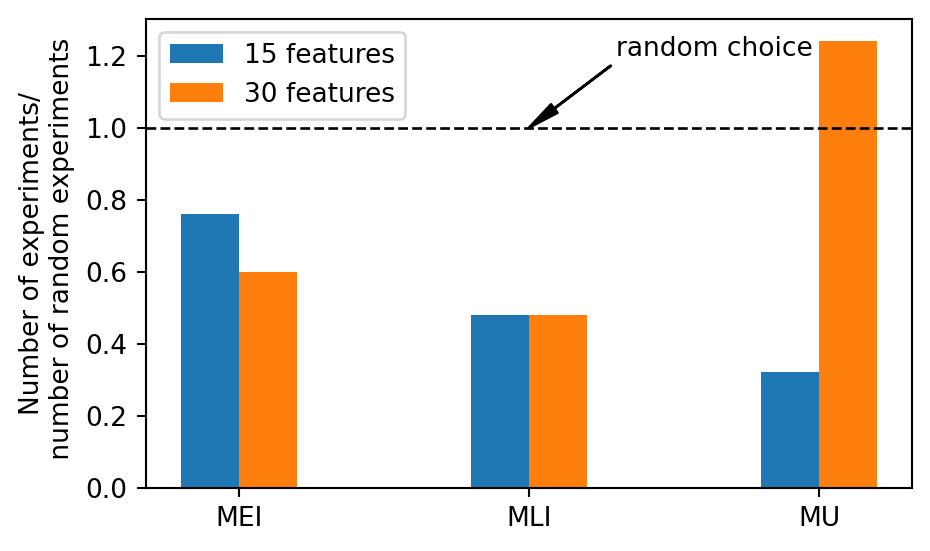

In [ ]:
N = 50 / 2  # number of evaluations in random choice
labels = ["MEI", "MLI", "MU"]
relevant = [
    19 / N,
    12 / N,
    8 / N,
]  # replace numbers with the numbers of evaluations performed by SL for MEI, MLI, MU with only relevant features
all = [
    15 / N,
    12 / N,
    31 / N,
]  # replace numbers with the numbers of evaluations performed by SL for MEI, MLI, MU with also unrelevant features

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3), dpi=190)

rects1 = ax.bar(x - width / 2, relevant, width, label="15 features")
rects2 = ax.bar(x + width / 2, all, width, label="30 features")
plt.axhline(y=1, color="k", linewidth=1, linestyle="--")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of experiments/\n number of random experiments")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.annotate(
    "random choice",
    xy=(1, 1),
    xytext=(1.3, 1.2),
    arrowprops=dict(facecolor="black", width=0.1, headwidth=4),
)


fig.tight_layout()

plt.show()